🙏 This notebook builds off of the work of @greysky's [Enefit Generic Notebook](https://www.kaggle.com/code/greysky/enefit-generic-notebook) and @patrick0302's [Do you desire sun power](https://www.kaggle.com/code/patrick0302/do-you-desire-sun-power)

We will build two models, one for energy production and one for energy consumption, and build our prediction from the output of these two.

In [1]:
import datetime
import os
import gc
import holidays
import pickle

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor

import lightgbm as lgb

import optuna

/venv-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility functions and classes

In [2]:
class MonthlyKFold:
    def __init__(self, n_splits=3):
        self.n_splits = n_splits
        
    def split(self, X, y, groups=None):
        dates = 12 * X["year"] + X["month"]
        timesteps = sorted(dates.unique().tolist())
        X = X.reset_index()
        
        for t in timesteps[-self.n_splits:]:
            idx_train = X[dates.values < t].index
            idx_test = X[dates.values == t].index
            
            yield idx_train, idx_test
            
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [3]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )
    
    # Installed capacity as of 2 days prior
    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )
    
    # Next-day forecasted gas prices
    df_gas = (
        df_gas
        .rename({
            "forecast_date": "date", 
            "lowest_price_per_mwh": "lowest_gas_price_per_mwh", 
            "highest_price_per_mwh": "highest_gas_price_per_mwh"
            })
        # .with_columns(
        #     (pl.col("date") + pl.duration(days=1)).cast(pl.Date)
        # )
    )
    
    # Forecasted electricity prices for each hour
    df_electricity = (
        df_electricity
        .rename({
            "forecast_date": "datetime",
            "euros_per_mwh": "electricity_price_per_mwh"
        })
        # .with_columns(
        #     pl.col("datetime") + pl.duration(days=1)
        # )
    )
    
    # Locations of weather stations
    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )
    
    # Weather forecast data, up to 48 hours ahead, generated each hour
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    # Historical weather data, generated each hour
    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
            # pl.col("datetime") + pl.duration(hours=37)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    ## Feature engineering starts here ##

    # Mean forecast weather over whole geography
    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county", "hours_ahead")
    )
    
    # Mean forecast weather by county
    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    # Mean historical weather over whole geography
    df_historical_date = (
        df_historical
        .group_by("datetime").mean()
        .drop("county", "hours_ahead")
    )
    
    # Mean historical weather by county
    df_historical_local = (
        df_historical
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )

    # Target sum by product type
    df_target_type_sum = (
        df_target
        .group_by("datetime", "county", "is_business", "is_consumption").sum()
        .drop("product_type")
    )

    df_target_type_sum_local = (
        df_target
        .group_by("datetime", "is_business", "is_consumption").sum()
        .drop("county", "product_type")
    )

    # Merge in gas and electricity prices
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
    )

    for n_days_back in [1, 2]:
        df_data = (
            df_data
            .join(df_gas.with_columns(pl.col("date") + pl.duration(days=n_days_back)), on="date", how="left", suffix="_{}d".format(n_days_back))
            .join(df_electricity.with_columns(pl.col("datetime") + pl.duration(days=n_days_back)), on="datetime", how="left", suffix="_{}d".format(n_days_back))
        )

    # Add weather features
    df_data = (
        df_data
        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_historical_date, on="datetime", how="left", suffix="_hd")
        .join(df_historical_local, on=["county", "datetime"], how="left", suffix="_hl")
    )

    # for n_days_back in [7]:
    #     df_data = (
    #         df_data
    #         .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(days=n_days_back)), on="datetime", how="left", suffix="_fd_{}d".format(n_days_back))
    #         .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(days=n_days_back)), on=["county", "datetime"], how="left", suffix="_fl_{}d".format(n_days_back))
    #         .join(df_historical_date.with_columns(pl.col("datetime") + pl.duration(days=n_days_back)), on="datetime", how="left", suffix="_hd_{}d".format(n_days_back))
    #         .join(df_historical_local.with_columns(pl.col("datetime") + pl.duration(days=n_days_back)), on=["county", "datetime"], how="left", suffix="_hl_{}d".format(n_days_back))
    #     )

    # for n_hours_back in [12]:
    #     df_data = (
    #         df_data
    #         .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(hours=n_hours_back)), on="datetime", how="left", suffix="_fd_{}h".format(n_hours_back))
    #         .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(hours=n_hours_back)), on=["county", "datetime"], how="left", suffix="_fl_{}h".format(n_hours_back))
    #         .join(df_historical_date.with_columns(pl.col("datetime") + pl.duration(hours=n_hours_back)), on="datetime", how="left", suffix="_hd_{}h".format(n_hours_back))
    #         .join(df_historical_local.with_columns(pl.col("datetime") + pl.duration(hours=n_hours_back)), on=["county", "datetime"], how="left", suffix="_hl_{}h".format(n_hours_back))
    #     )

    # Add target features
    for n_days_back in [2, 3, 4, 5, 6, 7, 14]:
        df_data = (
            df_data
            .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=n_days_back)).rename({"target": "target_{}".format(n_days_back)}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        )

    # Add target sum features
    for n_days_back in [2, 3, 7, 14]:
        df_data = (
            df_data
            .join(df_target_type_sum.with_columns(pl.col("datetime") + pl.duration(days=n_days_back)).rename({"target": "target_sum_{}".format(n_days_back)}), on=["county", "is_business", "is_consumption", "datetime"], how="left")
            .join(df_target_type_sum_local.with_columns(pl.col("datetime") + pl.duration(days=n_days_back)).rename({"target": "target_sum_local_{}".format(n_days_back)}), on=["is_business", "is_consumption", "datetime"], how="left")
        )

    # Add target and target sum ratio features
    for ratio_pair in [("2", "3"), ("3", "7"), ("7", "14")]:
        df_data = (
            df_data
            .with_columns(
                (pl.col("target_{}".format(ratio_pair[0])) / (pl.col("target_{}".format(ratio_pair[1])) + 1e-3)).alias("target_{}_ratio".format("_".join(ratio_pair))),
                (pl.col("target_sum_{}".format(ratio_pair[0])) / (pl.col("target_sum_{}".format(ratio_pair[1])) + 1e-3)).alias("target_sum_{}_ratio".format("_".join(ratio_pair))),
                (pl.col("target_sum_local_{}".format(ratio_pair[0])) / (pl.col("target_sum_local_{}".format(ratio_pair[1])) + 1e-3)).alias("target_sum_local_{}_ratio".format("_".join(ratio_pair)))
            )
        )

    # Add target stats features
    cols_for_stats = ["target_{}".format(n_days_back) for n_days_back in [2, 3, 4, 5]]
    df_data = (
        df_data
        .with_columns(
            df_data.select(cols_for_stats).mean(axis=1).alias("target_mean"),
            df_data.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )
    )

    # Add cyclical date features and the named segment
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )
        
        .with_columns(
            pl.concat_str("county", "is_business", "product_type", separator="_").alias("segment"),
        )

        # .with_columns(
        #     pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("segment_plus"),
        # )

        .with_columns(
            (2 * np.pi * pl.col("dayofyear") / 365).sin().alias("sin(dayofyear)"),
            (2 * np.pi * pl.col("dayofyear") / 365).cos().alias("cos(dayofyear)"),
            # (2 * np.pi * pl.col("day") / 31).sin().alias("sin(dayofmonth)"),
            # (2 * np.pi * pl.col("day") / 31).cos().alias("cos(dayofmonth)"),
            (2 * np.pi * pl.col("hour") / 24).sin().alias("sin(hour)"),
            (2 * np.pi * pl.col("hour") / 24).cos().alias("cos(hour)"),
        )
        
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        
        .drop("date", "datetime", "dayofyear")
    )
    
    return df_data

In [4]:
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption", "segment", "is_holiday", "weekday"]  # add back "segment_plus" if using it
    
    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()    
    
    # Identify holidays as a binary feature
    estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
    estonian_holidays_keys = list(estonian_holidays.keys())
    df["temp_date"] = pd.to_datetime(df[['year', 'month', 'day']])
    df['is_holiday'] = df["temp_date"].isin(estonian_holidays_keys).astype(int)
    df.drop(columns=["temp_date"], inplace=True)

    # Linearly interpolate some of the missing data
    # all_seg = list(set(df["segment_plus"]))
    # all_seg.sort()
    # df_dict = {}
    # for seg in all_seg:
    #     df_dict[seg] = df[df["segment_plus"] == seg].copy()
    #     df_dict[seg].sort_values(by=["year", "month", "day", "hour"], inplace=True)
    #     df_dict[seg].reset_index(inplace=True)
    #     df_dict[seg].drop(columns=["index"], inplace=True)
    #     df_dict[seg].interpolate(method="linear", limit_direction="both", inplace=True)
    #     df.update(df_dict[seg])

    df.drop(columns=["day", "hour"], inplace=True)
    df["month_cat"] = df["month"].astype("category")    # Month feature is separate because it is also used in computing cross-validation folds

    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")
    
    return df

In [5]:
def lgb_p_objective(trial):
    params = {
        'n_iter'           : 1000,
        'verbose'          : -1,
        'random_state'     : 42,
        'objective'        : 'l1',
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'lambda_l1'        : trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2'        : trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 4, 512),
        'max_depth'        : trial.suggest_int('max_depth', 5, 12),
        'max_bin'          : trial.suggest_int('max_bin', 32, 1024),
        'num_leaves'       : trial.suggest_int('num_leaves', 16, 512),
    }
    
    model  = lgb.LGBMRegressor(**params)
    X, y   = df_train[df_train['is_consumption']==0].drop(columns=["target"]), df_train[df_train['is_consumption']==0]["target"]
    cv     = MonthlyKFold(1)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    return -1 * np.mean(scores)

In [6]:
def lgb_c_objective(trial):
    params = {
        'n_iter'           : 1000,
        'verbose'          : -1,
        'random_state'     : 42,
        'objective'        : 'l1',
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'lambda_l1'        : trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2'        : trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 4, 512),
        'max_depth'        : trial.suggest_int('max_depth', 5, 12),
        'max_bin'          : trial.suggest_int('max_bin', 32, 1024),
        'num_leaves'       : trial.suggest_int('num_leaves', 16, 512),
    }
    
    model  = lgb.LGBMRegressor(**params)
    X, y   = df_train[df_train['is_consumption']==1].drop(columns=["target"]), df_train[df_train['is_consumption']==1]["target"]
    cv     = MonthlyKFold(1)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    return -1 * np.mean(scores)

In [7]:
# Utility cell to transfer between local and online notebook runs
root = "competition_data"
# root = "/kaggle/input/predict-energy-behavior-of-prosumers"

## Import data

In [8]:
data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

save_path = None # "trained_gbm_models_20231213.pkl"
load_path = None # "trained_gbm_models.pkl"

In [9]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema

## Feature Engineering

In [10]:
X, y = df_data.drop("target"), df_data.select("target")

X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)

df_train = to_pandas(X, y)

/tmp/ipykernel_58715/3765654012.py:192: DeprecationWarning: The `axis` parameter for `DataFrame.mean` is deprecated. Use `DataFrame.mean_horizontal()` to perform horizontal aggregation.
  df_data.select(cols_for_stats).mean(axis=1).alias("target_mean"),


In [11]:
# df_train = df_train[df_train["target"].notnull() & (df_train["year"].ge(2022))]
df_train = df_train[df_train["target"].notnull()]

In [12]:
list(df_train.columns)

['county',
 'is_business',
 'product_type',
 'is_consumption',
 'lowest_gas_price_per_mwh',
 'highest_gas_price_per_mwh',
 'eic_count',
 'installed_capacity',
 'electricity_price_per_mwh',
 'lowest_gas_price_per_mwh_1d',
 'highest_gas_price_per_mwh_1d',
 'electricity_price_per_mwh_1d',
 'lowest_gas_price_per_mwh_2d',
 'highest_gas_price_per_mwh_2d',
 'electricity_price_per_mwh_2d',
 'temperature',
 'dewpoint',
 'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 '10_metre_u_wind_component',
 '10_metre_v_wind_component',
 'direct_solar_radiation',
 'surface_solar_radiation_downwards',
 'snowfall',
 'total_precipitation',
 'hours_ahead',
 'temperature_fl',
 'dewpoint_fl',
 'cloudcover_high_fl',
 'cloudcover_low_fl',
 'cloudcover_mid_fl',
 'cloudcover_total_fl',
 '10_metre_u_wind_component_fl',
 '10_metre_v_wind_component_fl',
 'direct_solar_radiation_fl',
 'surface_solar_radiation_downwards_fl',
 'snowfall_fl',
 'total_precipitation_fl',
 'temperature_hd',
 'de

## HyperParam Optimization

Note: Optuna on my local machine takes several minutes per iteration!

In [13]:
study = optuna.create_study(direction='minimize', study_name='Regressor')
study.optimize(lgb_c_objective, n_trials=10, show_progress_bar=True)

[I 2024-01-03 23:24:03,352] A new study created in memory with name: Regressor
  0%|          | 0/10 [00:00<?, ?it/s]/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 0. Best value: 49.52:  10%|█         | 1/10 [11:36<1:44:32, 696.99s/it]

[I 2024-01-03 23:35:40,347] Trial 0 finished with value: 49.52003249703822 and parameters: {'learning_rate': 0.02957405755815657, 'colsample_bytree': 0.9263417021595994, 'colsample_bynode': 0.5727422013237646, 'lambda_l1': 2.853982242963171, 'lambda_l2': 9.200933417135202, 'min_data_in_leaf': 444, 'max_depth': 7, 'max_bin': 990, 'num_leaves': 161}. Best is trial 0 with value: 49.52003249703822.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 1. Best value: 49.1084:  20%|██        | 2/10 [21:11<1:23:17, 624.71s/it]

[I 2024-01-03 23:45:14,452] Trial 1 finished with value: 49.10841738102939 and parameters: {'learning_rate': 0.058948426486757605, 'colsample_bytree': 0.5070056948479258, 'colsample_bynode': 0.5057733151574602, 'lambda_l1': 6.223817587942942, 'lambda_l2': 2.4768339498981113, 'min_data_in_leaf': 87, 'max_depth': 11, 'max_bin': 624, 'num_leaves': 230}. Best is trial 1 with value: 49.10841738102939.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 1. Best value: 49.1084:  30%|███       | 3/10 [32:10<1:14:44, 640.59s/it]

[I 2024-01-03 23:56:13,933] Trial 2 finished with value: 49.63977685778285 and parameters: {'learning_rate': 0.035783173932395156, 'colsample_bytree': 0.9197769154709734, 'colsample_bynode': 0.578583746627955, 'lambda_l1': 5.330932279661255, 'lambda_l2': 2.726695447182785, 'min_data_in_leaf': 308, 'max_depth': 10, 'max_bin': 733, 'num_leaves': 59}. Best is trial 1 with value: 49.10841738102939.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 1. Best value: 49.1084:  40%|████      | 4/10 [42:42<1:03:43, 637.29s/it]

[I 2024-01-04 00:06:46,162] Trial 3 finished with value: 49.17126545822352 and parameters: {'learning_rate': 0.04376266468343627, 'colsample_bytree': 0.7835946467067356, 'colsample_bynode': 0.8846978654744354, 'lambda_l1': 5.405085429501305, 'lambda_l2': 0.5773876151909174, 'min_data_in_leaf': 492, 'max_depth': 12, 'max_bin': 729, 'num_leaves': 79}. Best is trial 1 with value: 49.10841738102939.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 1. Best value: 49.1084:  50%|█████     | 5/10 [51:08<49:08, 589.77s/it]  

[I 2024-01-04 00:15:11,682] Trial 4 finished with value: 50.202280227729595 and parameters: {'learning_rate': 0.07831851390666915, 'colsample_bytree': 0.9188477658756748, 'colsample_bynode': 0.9236213384368831, 'lambda_l1': 5.150641398375739, 'lambda_l2': 9.593502018974881, 'min_data_in_leaf': 353, 'max_depth': 6, 'max_bin': 641, 'num_leaves': 145}. Best is trial 1 with value: 49.10841738102939.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 1. Best value: 49.1084:  60%|██████    | 6/10 [58:22<35:47, 536.80s/it]

[I 2024-01-04 00:22:25,652] Trial 5 finished with value: 49.13950583509172 and parameters: {'learning_rate': 0.04665808445675919, 'colsample_bytree': 0.5159825524050927, 'colsample_bynode': 0.5541050167756041, 'lambda_l1': 1.3318652106600608, 'lambda_l2': 6.178169339686278, 'min_data_in_leaf': 142, 'max_depth': 9, 'max_bin': 439, 'num_leaves': 486}. Best is trial 1 with value: 49.10841738102939.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 6. Best value: 48.2174:  70%|███████   | 7/10 [1:13:39<33:03, 661.27s/it]

[I 2024-01-04 00:37:43,199] Trial 6 finished with value: 48.21739531485862 and parameters: {'learning_rate': 0.07854940183828686, 'colsample_bytree': 0.7628643368333998, 'colsample_bynode': 0.8554036670542124, 'lambda_l1': 7.753662256212569, 'lambda_l2': 4.403387197429015, 'min_data_in_leaf': 416, 'max_depth': 12, 'max_bin': 920, 'num_leaves': 247}. Best is trial 6 with value: 48.21739531485862.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 6. Best value: 48.2174:  80%|████████  | 8/10 [1:25:57<22:51, 685.52s/it]

[I 2024-01-04 00:50:00,625] Trial 7 finished with value: 49.6095270793297 and parameters: {'learning_rate': 0.05891884428959911, 'colsample_bytree': 0.8865837686791308, 'colsample_bynode': 0.7603695278678648, 'lambda_l1': 7.115653171929787, 'lambda_l2': 6.521835525826188, 'min_data_in_leaf': 407, 'max_depth': 9, 'max_bin': 574, 'num_leaves': 331}. Best is trial 6 with value: 48.21739531485862.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 6. Best value: 48.2174:  90%|█████████ | 9/10 [1:32:18<09:50, 590.39s/it]

[I 2024-01-04 00:56:21,838] Trial 8 finished with value: 51.22911752646734 and parameters: {'learning_rate': 0.07729303624817224, 'colsample_bytree': 0.6820317281032144, 'colsample_bynode': 0.8342640837265722, 'lambda_l1': 3.362460353779044, 'lambda_l2': 8.043727063419485, 'min_data_in_leaf': 506, 'max_depth': 6, 'max_bin': 446, 'num_leaves': 295}. Best is trial 6 with value: 48.21739531485862.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 6. Best value: 48.2174: 100%|██████████| 10/10 [1:42:33<00:00, 615.35s/it]

[I 2024-01-04 01:06:36,883] Trial 9 finished with value: 49.492913565354 and parameters: {'learning_rate': 0.09702066488296911, 'colsample_bytree': 0.8429313387443451, 'colsample_bynode': 0.7314677135049097, 'lambda_l1': 5.871304713413701, 'lambda_l2': 7.370702537878786, 'min_data_in_leaf': 118, 'max_depth': 9, 'max_bin': 182, 'num_leaves': 407}. Best is trial 6 with value: 48.21739531485862.


In [14]:
study = optuna.create_study(direction='minimize', study_name='Regressor')
study.optimize(lgb_p_objective, n_trials=10, show_progress_bar=True)

[I 2024-01-04 01:06:36,897] A new study created in memory with name: Regressor
  0%|          | 0/10 [00:00<?, ?it/s]/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 0. Best value: 82.3232:  10%|█         | 1/10 [10:40<1:36:04, 640.51s/it]

[I 2024-01-04 01:17:17,409] Trial 0 finished with value: 82.32319727248651 and parameters: {'learning_rate': 0.07763414762833658, 'colsample_bytree': 0.7876874585700728, 'colsample_bynode': 0.5973306799742458, 'lambda_l1': 3.000692491946105, 'lambda_l2': 3.5936894894107905, 'min_data_in_leaf': 213, 'max_depth': 8, 'max_bin': 962, 'num_leaves': 465}. Best is trial 0 with value: 82.32319727248651.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 1. Best value: 82.0116:  20%|██        | 2/10 [18:12<1:10:37, 529.70s/it]

[I 2024-01-04 01:24:49,537] Trial 1 finished with value: 82.01159046959808 and parameters: {'learning_rate': 0.06055499025888747, 'colsample_bytree': 0.7301039478224713, 'colsample_bynode': 0.9461474321467913, 'lambda_l1': 8.975058627606296, 'lambda_l2': 1.3395576533684408, 'min_data_in_leaf': 481, 'max_depth': 7, 'max_bin': 860, 'num_leaves': 444}. Best is trial 1 with value: 82.01159046959808.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 2. Best value: 81.2407:  30%|███       | 3/10 [26:53<1:01:20, 525.82s/it]

[I 2024-01-04 01:33:30,749] Trial 2 finished with value: 81.24067002369316 and parameters: {'learning_rate': 0.02138755825006871, 'colsample_bytree': 0.968675987585861, 'colsample_bynode': 0.5008295255583287, 'lambda_l1': 8.225631230145744, 'lambda_l2': 7.474496314551114, 'min_data_in_leaf': 110, 'max_depth': 8, 'max_bin': 391, 'num_leaves': 96}. Best is trial 2 with value: 81.24067002369316.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 2. Best value: 81.2407:  40%|████      | 4/10 [34:09<49:01, 490.21s/it]  

[I 2024-01-04 01:40:46,357] Trial 3 finished with value: 86.50300565715884 and parameters: {'learning_rate': 0.024735873262958407, 'colsample_bytree': 0.8755463214361507, 'colsample_bynode': 0.7668387658160134, 'lambda_l1': 2.209519013153067, 'lambda_l2': 0.6398403855392906, 'min_data_in_leaf': 326, 'max_depth': 8, 'max_bin': 600, 'num_leaves': 35}. Best is trial 2 with value: 81.24067002369316.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 4. Best value: 79.4655:  50%|█████     | 5/10 [45:35<46:44, 560.87s/it]

[I 2024-01-04 01:52:12,525] Trial 4 finished with value: 79.46549448355687 and parameters: {'learning_rate': 0.07136427297012335, 'colsample_bytree': 0.9417623821333714, 'colsample_bynode': 0.748614612136722, 'lambda_l1': 5.614243694016752, 'lambda_l2': 5.2849083372279555, 'min_data_in_leaf': 148, 'max_depth': 8, 'max_bin': 913, 'num_leaves': 175}. Best is trial 4 with value: 79.46549448355687.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 4. Best value: 79.4655:  60%|██████    | 6/10 [51:47<33:06, 496.54s/it]

[I 2024-01-04 01:58:24,191] Trial 5 finished with value: 81.03361422517759 and parameters: {'learning_rate': 0.07784073400418398, 'colsample_bytree': 0.6479655384137065, 'colsample_bynode': 0.7333468521729358, 'lambda_l1': 8.705916571823913, 'lambda_l2': 8.754341115789147, 'min_data_in_leaf': 57, 'max_depth': 6, 'max_bin': 785, 'num_leaves': 147}. Best is trial 4 with value: 79.46549448355687.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 6. Best value: 77.3589:  70%|███████   | 7/10 [1:01:01<25:46, 515.46s/it]

[I 2024-01-04 02:07:38,585] Trial 6 finished with value: 77.35894939382632 and parameters: {'learning_rate': 0.029533421197376897, 'colsample_bytree': 0.7377049252503751, 'colsample_bynode': 0.8346607510480226, 'lambda_l1': 7.7852991399476235, 'lambda_l2': 6.408625366124916, 'min_data_in_leaf': 42, 'max_depth': 8, 'max_bin': 981, 'num_leaves': 99}. Best is trial 6 with value: 77.35894939382632.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 6. Best value: 77.3589:  80%|████████  | 8/10 [1:09:27<17:04, 512.30s/it]

[I 2024-01-04 02:16:04,121] Trial 7 finished with value: 78.53656502978765 and parameters: {'learning_rate': 0.05704221379918847, 'colsample_bytree': 0.9159905004202691, 'colsample_bynode': 0.7445680668083505, 'lambda_l1': 8.383819968228785, 'lambda_l2': 2.0166583059712355, 'min_data_in_leaf': 22, 'max_depth': 10, 'max_bin': 810, 'num_leaves': 52}. Best is trial 6 with value: 77.35894939382632.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 6. Best value: 77.3589:  90%|█████████ | 9/10 [1:14:54<07:34, 454.53s/it]

[I 2024-01-04 02:21:31,630] Trial 8 finished with value: 88.38861047451276 and parameters: {'learning_rate': 0.0693822379238915, 'colsample_bytree': 0.8832364575348373, 'colsample_bynode': 0.8435948822618816, 'lambda_l1': 0.6179996971598671, 'lambda_l2': 6.317711134584818, 'min_data_in_leaf': 460, 'max_depth': 6, 'max_bin': 108, 'num_leaves': 205}. Best is trial 6 with value: 77.35894939382632.


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
Best trial: 6. Best value: 77.3589: 100%|██████████| 10/10 [1:19:56<00:00, 479.61s/it]

[I 2024-01-04 02:26:32,999] Trial 9 finished with value: 80.94387178292608 and parameters: {'learning_rate': 0.05959148344352392, 'colsample_bytree': 0.5295307136012353, 'colsample_bynode': 0.8748159968225021, 'lambda_l1': 6.566197463770454, 'lambda_l2': 4.129773410504631, 'min_data_in_leaf': 227, 'max_depth': 7, 'max_bin': 515, 'num_leaves': 358}. Best is trial 6 with value: 77.35894939382632.


In [15]:
# New strategy - pick 5 good sets of params based on Optuna and train 5 different GBM regressors with them
c_params_1 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.039094920453362776, 'colsample_bytree': 0.8855809323891072, 'colsample_bynode': 0.7440012874324065, 'lambda_l1': 0.08223491401589073, 'lambda_l2': 5.578134015204122, 'min_data_in_leaf': 456, 'max_depth': 11, 'max_bin': 743, 'num_leaves': 320
}

c_params_2 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.03872776533698073, 'colsample_bytree': 0.8152494135837629, 'colsample_bynode': 0.642020475018747, 'lambda_l1': 8.995307279818997, 'lambda_l2': 4.7474855179967905, 'min_data_in_leaf': 194, 'max_depth': 10, 'max_bin': 534, 'num_leaves': 309
} 

c_params_3 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.03057502297297092, 'colsample_bytree': 0.97392330245017, 'colsample_bynode': 0.865865870694964, 'lambda_l1': 2.4913832790576955, 'lambda_l2': 8.947117956200923, 'min_data_in_leaf': 73, 'max_depth': 10, 'max_bin': 185, 'num_leaves': 494
}

c_params_4 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.07709725515955229, 'colsample_bytree': 0.7574401570315595, 'colsample_bynode': 0.590848828990752, 'lambda_l1': 8.60047381354025, 'lambda_l2': 0.6135213217642773, 'min_data_in_leaf': 161, 'max_depth': 8, 'max_bin': 931, 'num_leaves': 63
}

c_params_5 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.036755822302711606, 'colsample_bytree': 0.6791325942211803, 'colsample_bynode': 0.9782301356640646, 'lambda_l1': 2.182729047315563, 'lambda_l2': 0.25787250768070746, 'min_data_in_leaf': 276, 'max_depth': 12, 'max_bin': 778, 'num_leaves': 217
}

# Repeat this process for the models used for energy production
p_params_1 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.07786046448718871, 'colsample_bytree': 0.9180229898467425, 'colsample_bynode': 0.9167564058764461, 'lambda_l1': 1.7187815441855794, 'lambda_l2': 0.7374016340055326, 'min_data_in_leaf': 79, 'max_depth': 10, 'max_bin': 827, 'num_leaves': 143
}

p_params_2 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.07786046448718871, 'colsample_bytree': 0.9180229898467425, 'colsample_bynode': 0.9167564058764461, 'lambda_l1': 1.7187815441855794, 'lambda_l2': 0.7374016340055326, 'min_data_in_leaf': 79, 'max_depth': 10, 'max_bin': 827, 'num_leaves': 143
}

p_params_3 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.07786046448718871, 'colsample_bytree': 0.9180229898467425, 'colsample_bynode': 0.9167564058764461, 'lambda_l1': 1.7187815441855794, 'lambda_l2': 0.7374016340055326, 'min_data_in_leaf': 79, 'max_depth': 10, 'max_bin': 827, 'num_leaves': 143
}

p_params_4 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.07786046448718871, 'colsample_bytree': 0.9180229898467425, 'colsample_bynode': 0.9167564058764461, 'lambda_l1': 1.7187815441855794, 'lambda_l2': 0.7374016340055326, 'min_data_in_leaf': 79, 'max_depth': 10, 'max_bin': 827, 'num_leaves': 143
}

p_params_5 = {
    'n_iter': 1000, 'verbose': -1, 'objective': 'l1', 'learning_rate': 0.07786046448718871, 'colsample_bytree': 0.9180229898467425, 'colsample_bynode': 0.9167564058764461, 'lambda_l1': 1.7187815441855794, 'lambda_l2': 0.7374016340055326, 'min_data_in_leaf': 79, 'max_depth': 10, 'max_bin': 827, 'num_leaves': 143
}

## Validation

Fit and evaluation time is about 3min 30sec on my machine.

In [16]:
result = cross_validate(
    estimator=lgb.LGBMRegressor(**c_params_1, random_state=42),
    X=df_train[df_train['is_consumption']==1].drop(columns=["target"]), 
    y=df_train[df_train['is_consumption']==1]["target"],
    scoring="neg_mean_absolute_error",
    cv=MonthlyKFold(1),
)

print(f"Fit Time(s): {result['fit_time'].mean():.3f}")
print(f"Score Time(s): {result['score_time'].mean():.3f}")
print(f"Error(MAE): {-result['test_score'].mean():.3f}")

result_solar = cross_validate(
    estimator=lgb.LGBMRegressor(**p_params_1, random_state=42),
    X=df_train[df_train['is_consumption']==0].drop(columns=["target"]), 
    y=df_train[df_train['is_consumption']==0]["target"],
    scoring="neg_mean_absolute_error",
    cv=MonthlyKFold(1),
)

print(f"Fit Time(s): {result_solar['fit_time'].mean():.3f}")
print(f"Score Time(s): {result_solar['score_time'].mean():.3f}")
print(f"Error(MAE): {-result_solar['test_score'].mean():.3f}")

/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fit Time(s): 970.385
Score Time(s): 10.221
Error(MAE): 48.583


/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fit Time(s): 668.171
Score Time(s): 4.704
Error(MAE): 77.691


## Training full ensemble

In [17]:
if load_path is not None:
    load_solar_path = "_solar.".join(load_path.split("."))
    model = pickle.load(open(load_path, "rb"))
    model_solar = pickle.load(open(load_solar_path, "rb"))
else:
    model = VotingRegressor([
        ('lgb_1', lgb.LGBMRegressor(**c_params_1, random_state=100)), 
        ('lgb_2', lgb.LGBMRegressor(**c_params_2, random_state=101)), 
        ('lgb_3', lgb.LGBMRegressor(**c_params_3, random_state=102)), 
        ('lgb_4', lgb.LGBMRegressor(**c_params_4, random_state=103)), 
        ('lgb_5', lgb.LGBMRegressor(**c_params_5, random_state=104)), 
    ])
    
    model_solar = VotingRegressor([
        ('lgb_6', lgb.LGBMRegressor(**p_params_1, random_state=105)), 
        ('lgb_7', lgb.LGBMRegressor(**p_params_2, random_state=106)), 
        ('lgb_8', lgb.LGBMRegressor(**p_params_3, random_state=107)), 
        ('lgb_9', lgb.LGBMRegressor(**p_params_4, random_state=108)), 
        ('lgb_10', lgb.LGBMRegressor(**p_params_5, random_state=109)), 
    ])
    
    model.fit(
        X=df_train[df_train['is_consumption']==1].drop(columns=["target"]),
        y=df_train[df_train['is_consumption']==1]["target"]
    )
    
    model_solar.fit(
        X=df_train[df_train['is_consumption']==0].drop(columns=["target"]),
        y=df_train[df_train['is_consumption']==0]["target"]
    )

if save_path is not None:
    save_solar_path = "_solar.".join(save_path.split("."))
    with open(save_path, "wb") as f:
        pickle.dump(model, f)
    with open(save_solar_path, "wb") as f:
        pickle.dump(model_solar, f)

/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/venv-3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warnin

### Model Analysis

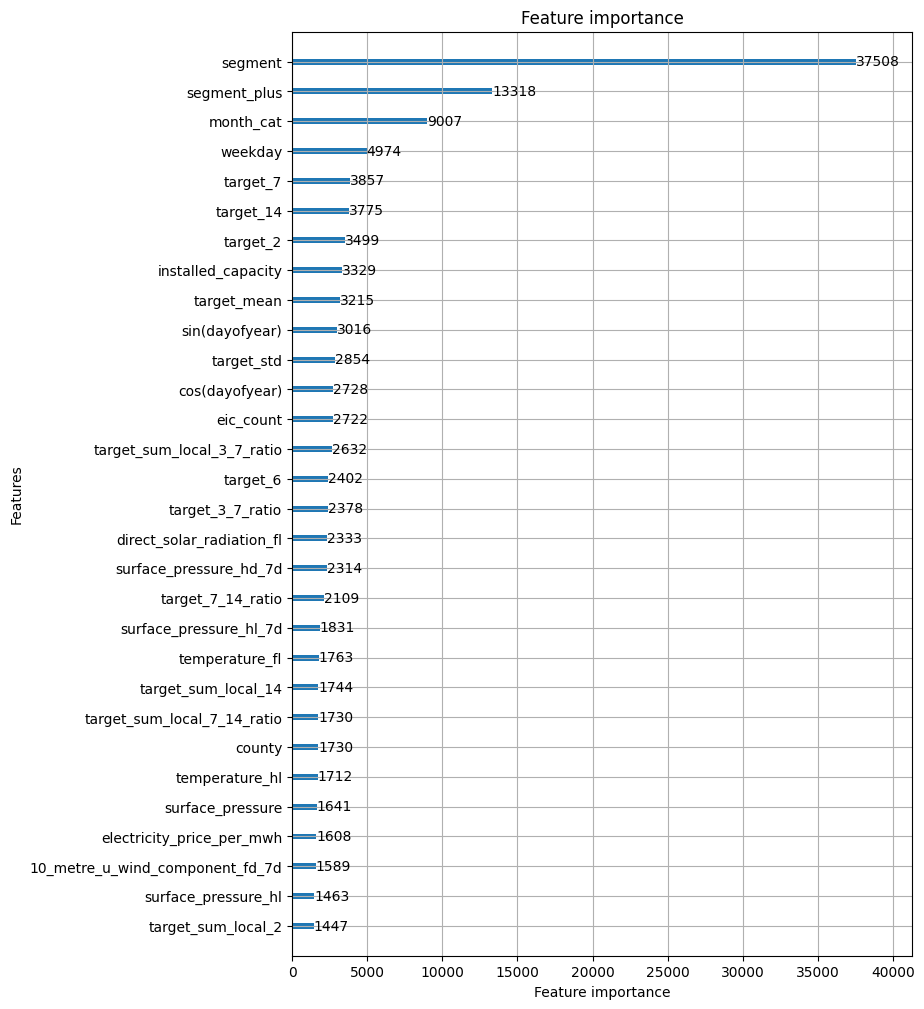

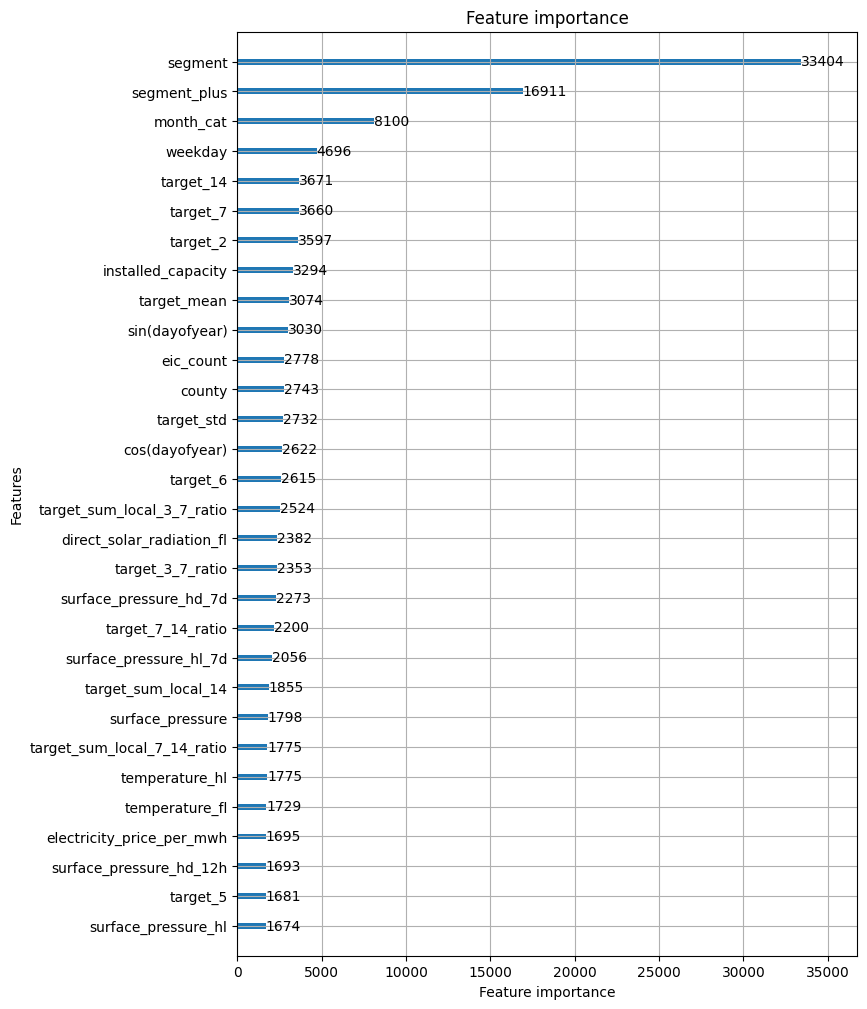

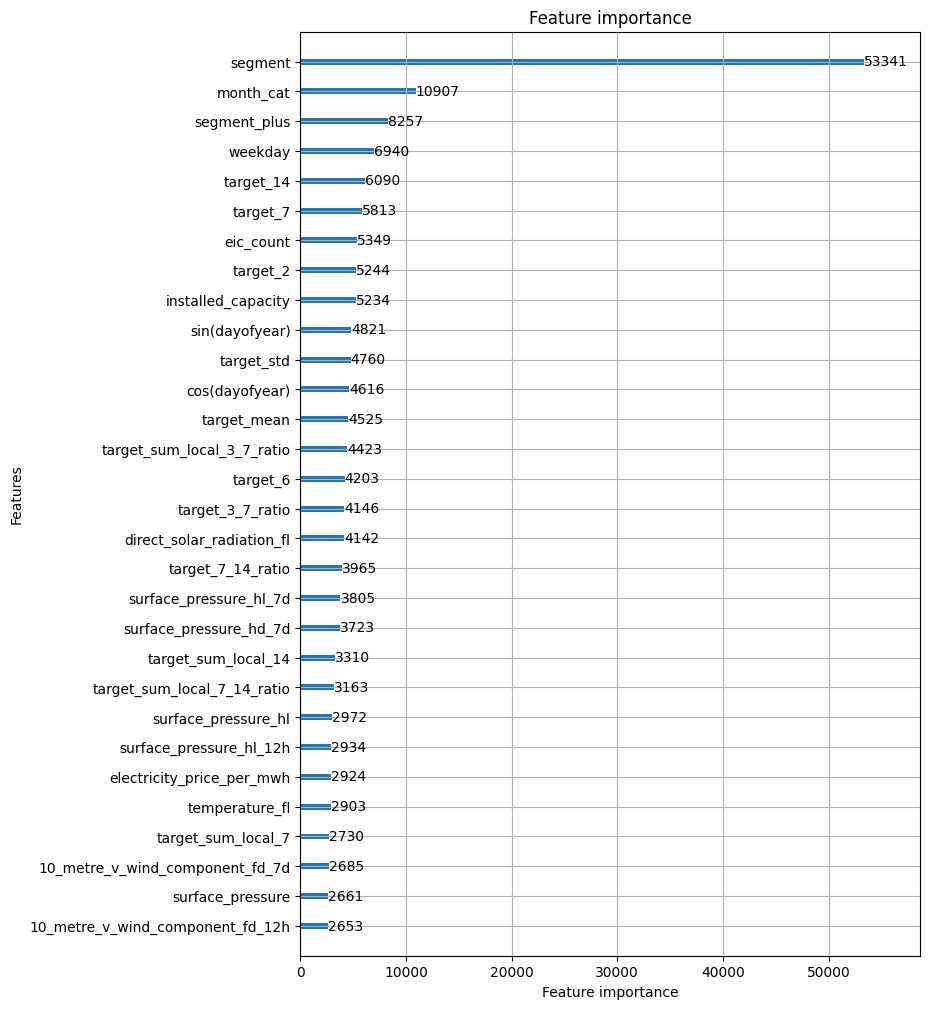

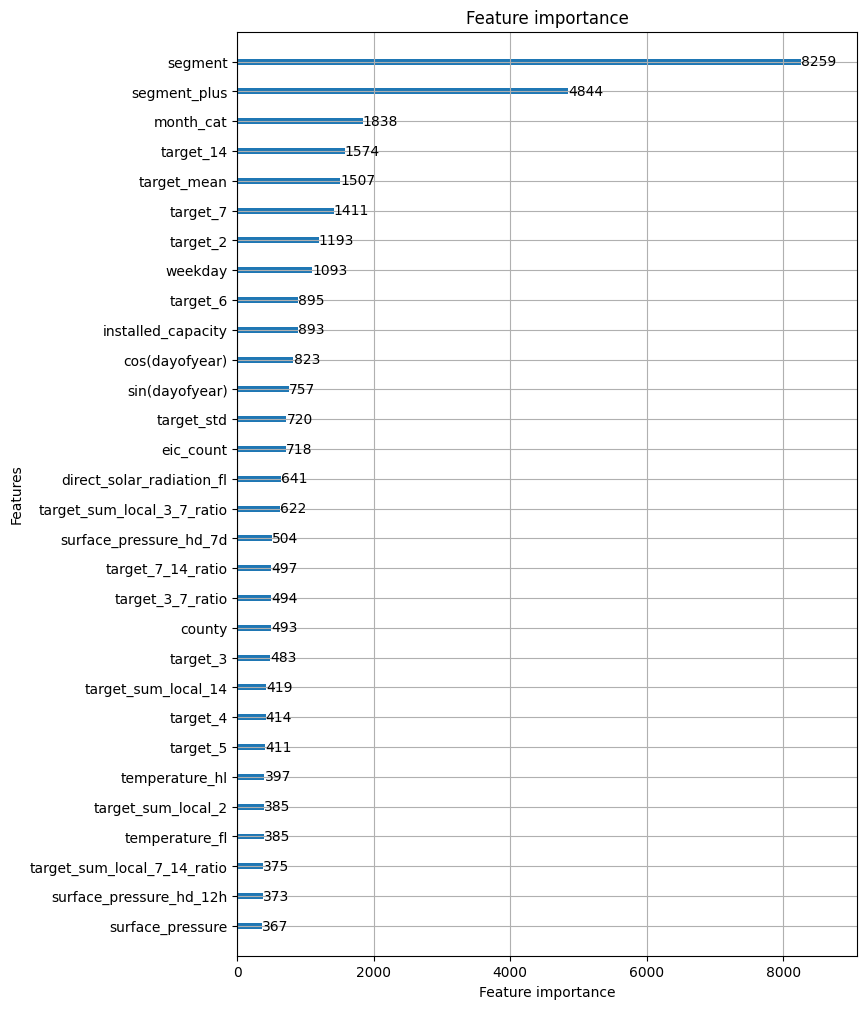

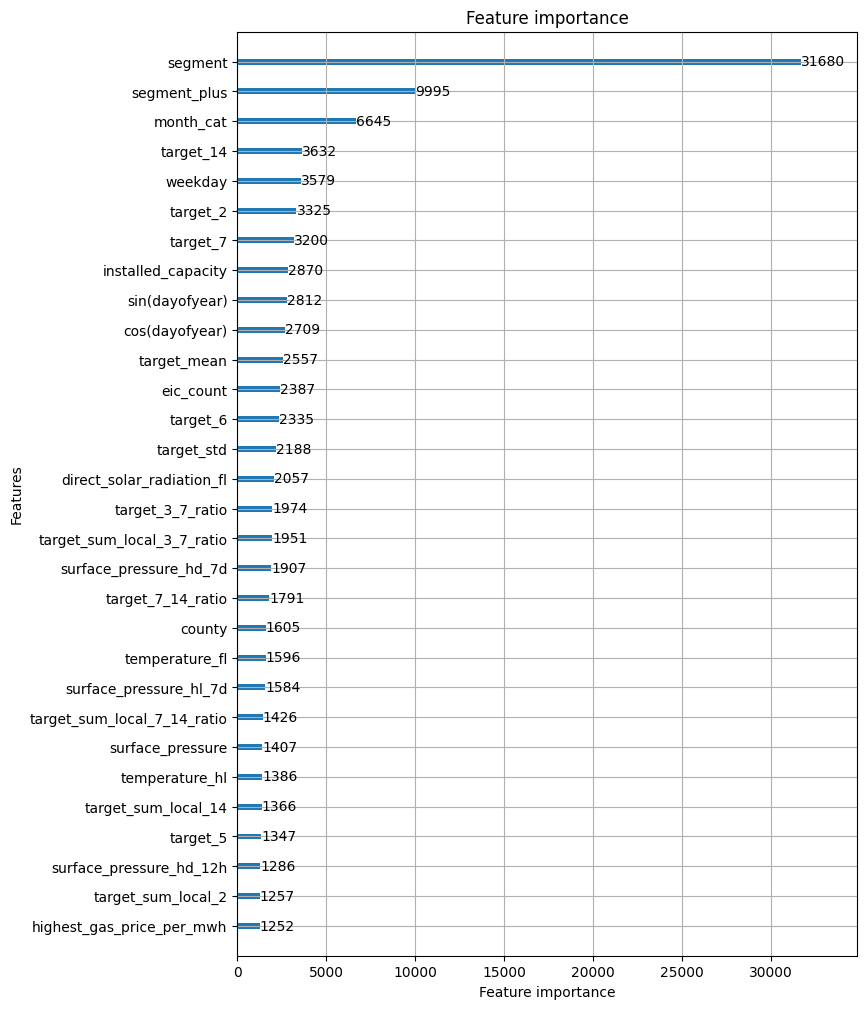

In [18]:
for i in range(5):
    lgb.plot_importance(model.estimators_[i], max_num_features=30, figsize=(8, 12))

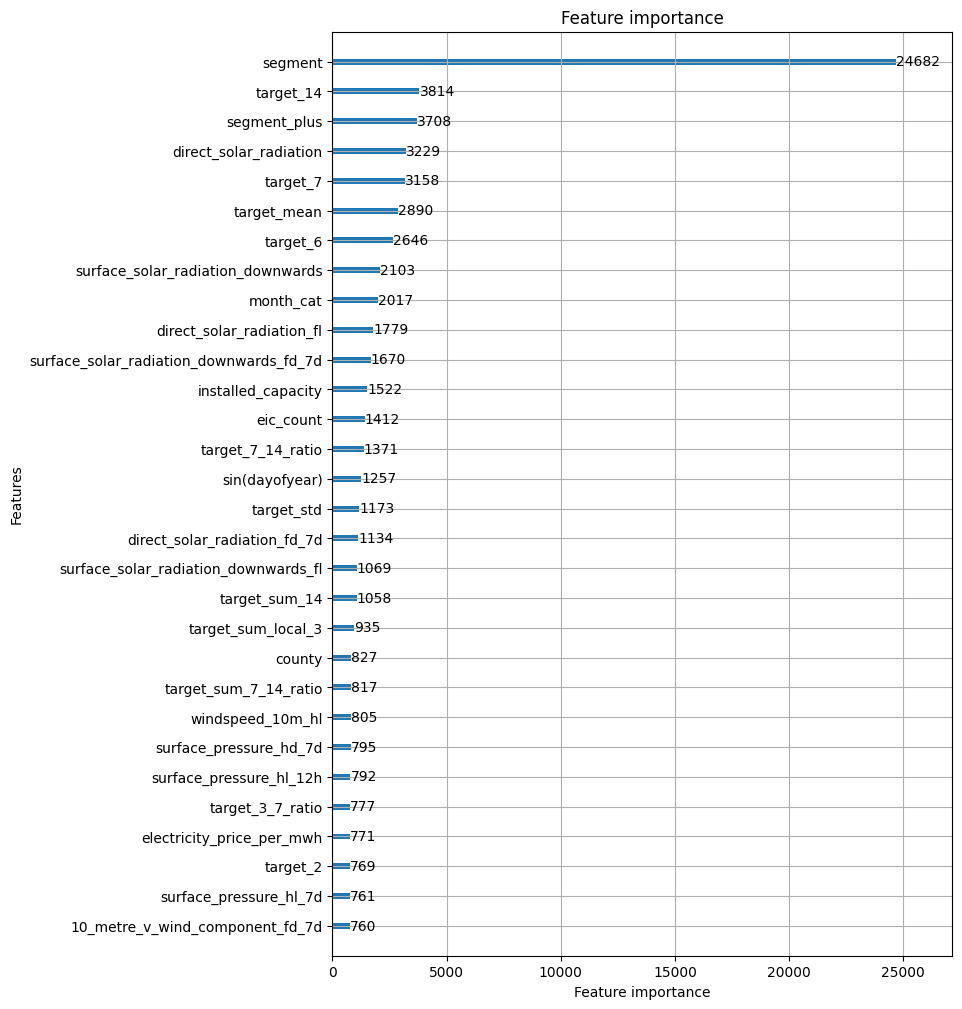

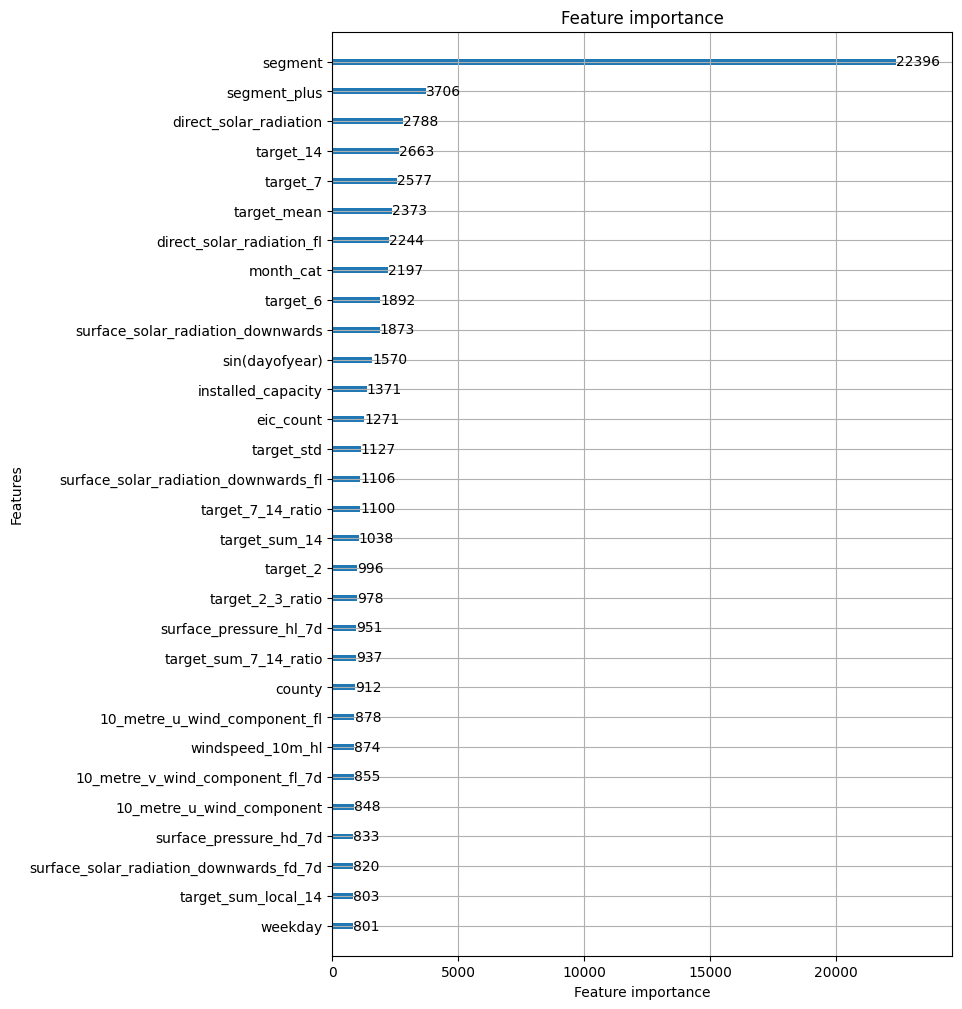

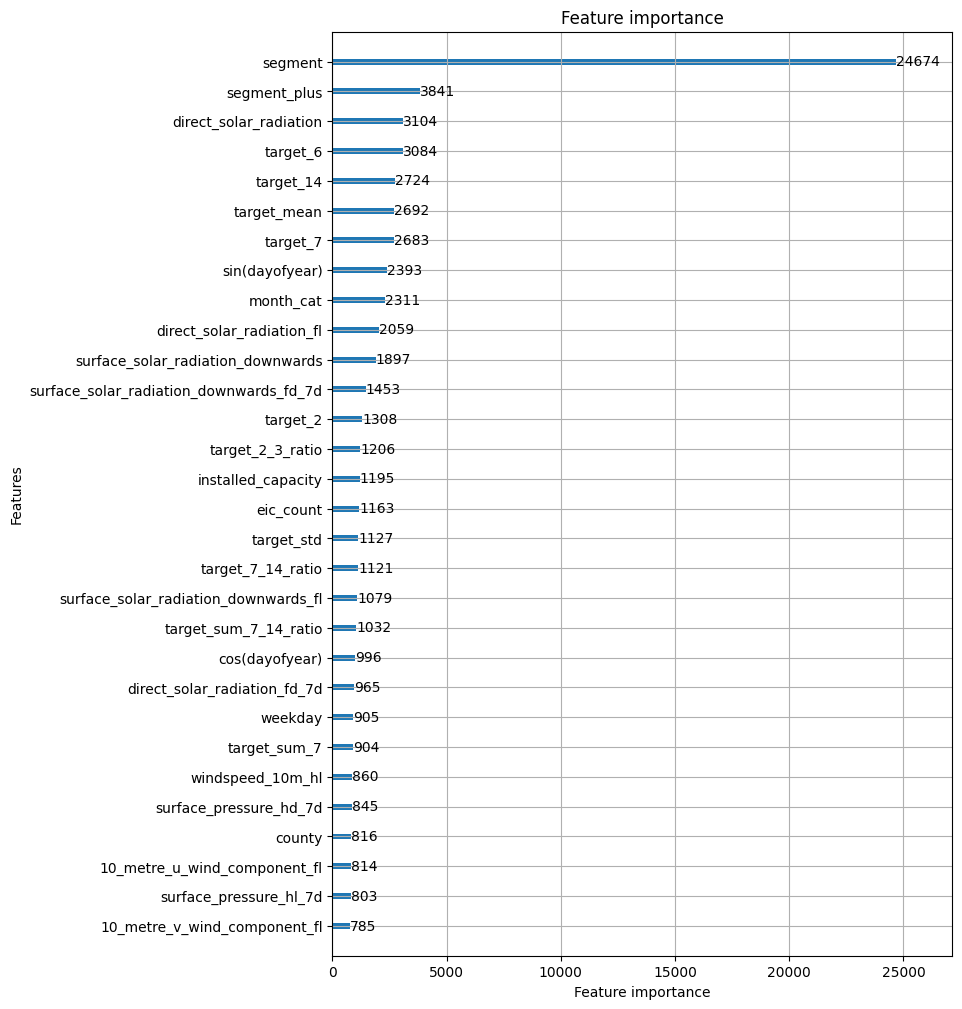

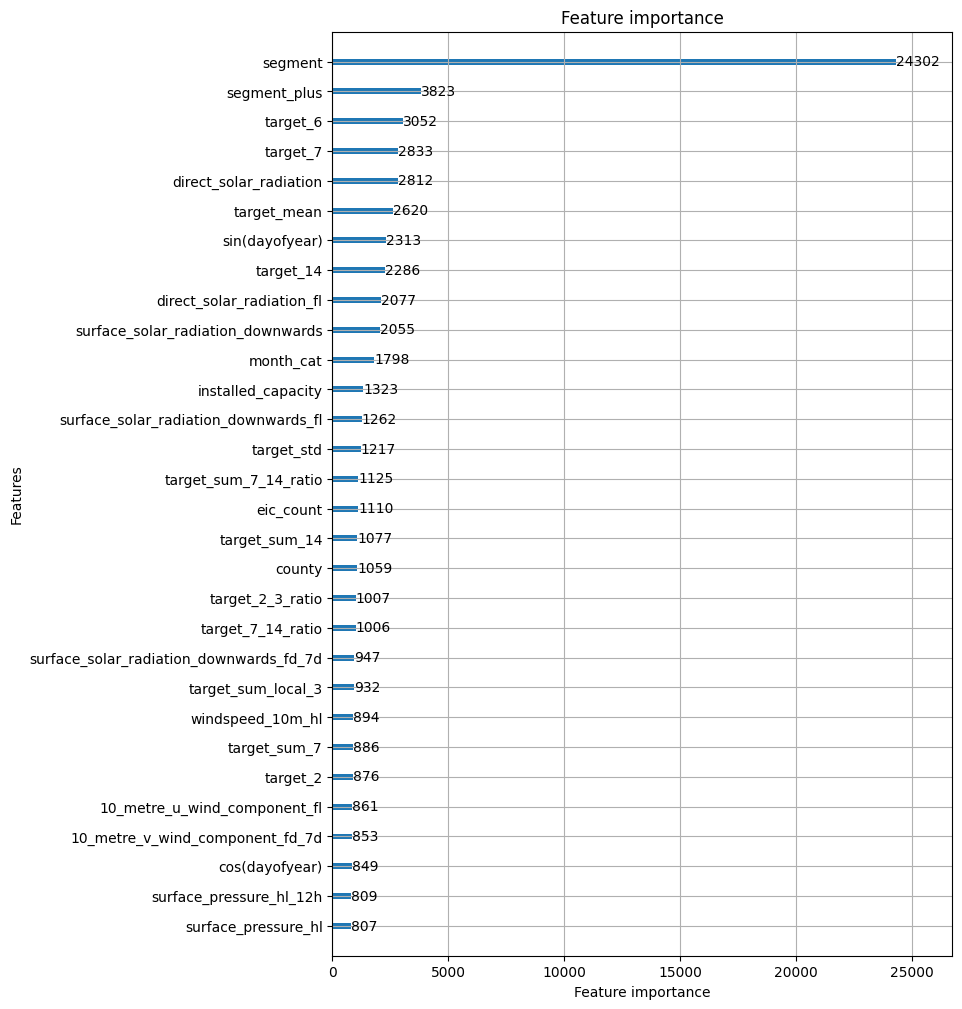

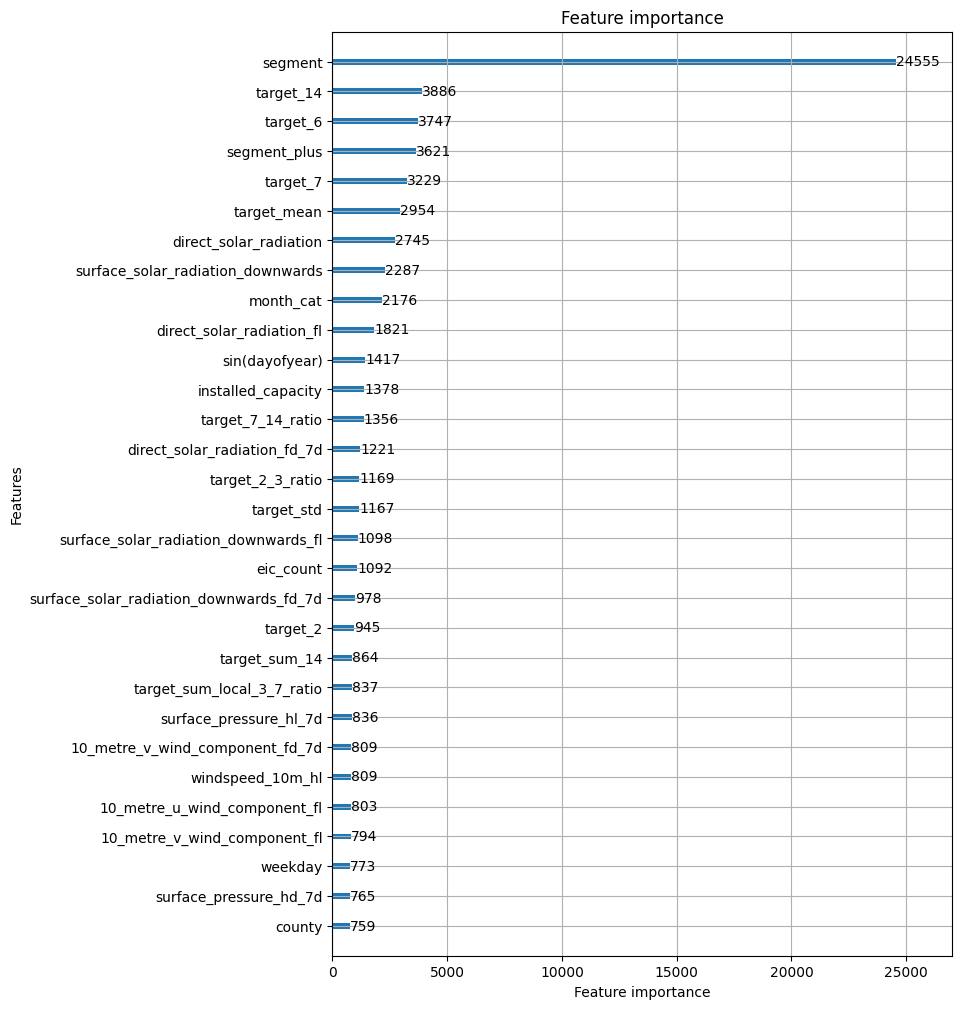

In [19]:
for i in range(5):
    lgb.plot_importance(model_solar.estimators_[i], max_num_features=30, figsize=(8, 12))

### Prediction

In [ ]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    test = test.rename(columns={"prediction_datetime": "datetime"})
    
    df_test           = pl.from_pandas(test[data_cols[1:]], schema_overrides=schema_data)
    df_client         = pl.from_pandas(client[client_cols], schema_overrides=schema_client)
    df_gas            = pl.from_pandas(gas_prices[gas_cols], schema_overrides=schema_gas)
    df_electricity    = pl.from_pandas(electricity_prices[electricity_cols], schema_overrides=schema_electricity)
    df_new_forecast   = pl.from_pandas(forecast_weather[forecast_cols], schema_overrides=schema_forecast)
    df_new_historical = pl.from_pandas(historical_weather[historical_cols], schema_overrides=schema_historical)
    df_new_target     = pl.from_pandas(revealed_targets[target_cols], schema_overrides=schema_target)
    
    df_forecast       = pl.concat([df_forecast, df_new_forecast]).unique()
    df_historical     = pl.concat([df_historical, df_new_historical]).unique()
    df_target         = pl.concat([df_target, df_new_target]).unique()
    
    X_test = feature_eng(df_test, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)
    X_test = to_pandas(X_test)
    
    test['target'] = model.predict(X_test).clip(0)
    test['target_solar'] = model_solar.predict(X_test).clip(0)
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]    
    
    sample_prediction["target"] = test['target']
    
    env.predict(sample_prediction)